In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Importing all the libraries

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.constraints import MaxNorm

Importing the dataset

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()



In [ ]:
#rotated_images = next(rotate_datagen.flow(X_train, y_train, batch_size=X_train.shape[0], shuffle=False))[0]

# Append augmented images to original training set
#X_train_aug = np.concatenate((X_train, rotated_images), axis=0)
#y_train_aug = np.concatenate((y_train, y_train), axis=0)



X_train shape: (100000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [5]:
#X_train = X_train_aug.astype('float32') / 255.0
#X_test = X_test.astype('float32') / 255.0
#y_train = y_train_aug.astype('int32') 

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


Threre are 50000 training images of size 32*32, each image has a single label from 0-9,

There are 10000 testing images of size 32*32, each image has a single label from 0-9

Below is a visualization of the images from the dataset:

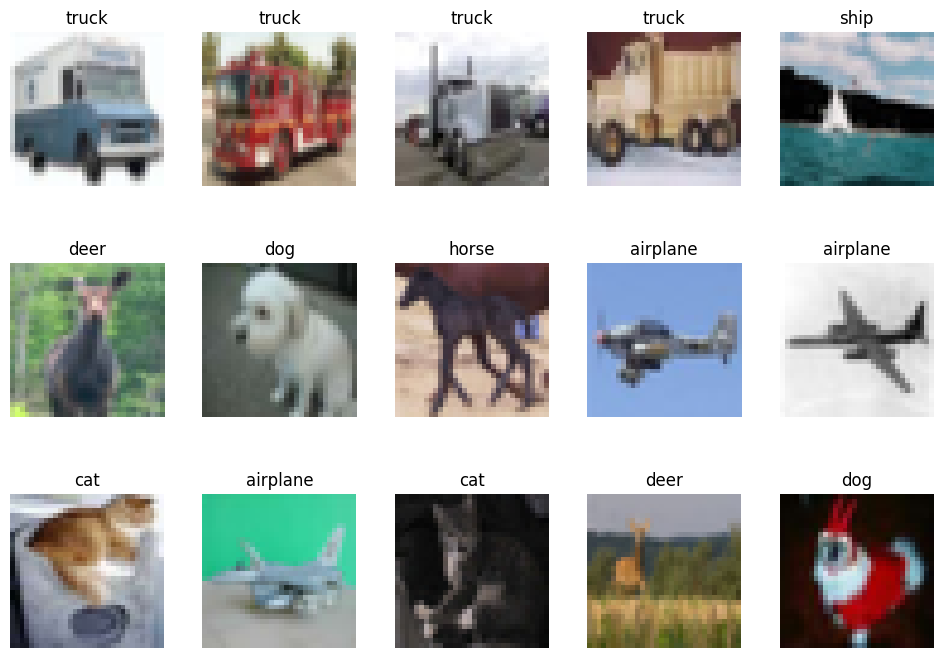

In [5]:
# Assuming x_train, y_train are loaded and contain CIFAR-10 data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.ravel()

for i in range(15):
    index = np.random.randint(0, len(X_train))
    axes[i].imshow(X_train[index])
    axes[i].set_title(class_names[y_train[index][0]])
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)

Analyse the dataset distribution (how many class-wise samples are there for training and testing)

C:\Users\EGE1\AppData\Local\Temp\ipykernel_10792\4180544181.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(class_names, rotation = 90)


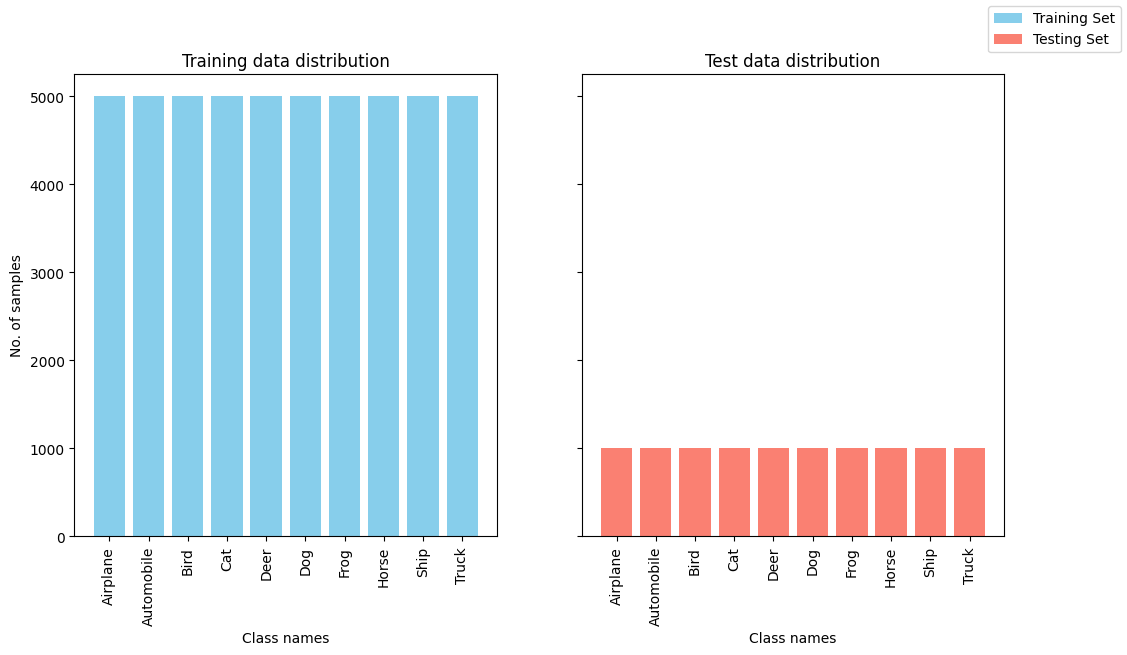

In [6]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot training set distribution
axs[0].bar(class_names, train_counts, color='skyblue')
axs[0].set_title('Training data distribution')
axs[0].set_xlabel('Class names')
axs[0].set_ylabel('No. of samples')
axs[0].set_xticklabels(class_names, rotation = 90)
# Plot testing set distribution
axs[1].bar(class_names, test_counts, color='salmon')
axs[1].set_title('Test data distribution')
axs[1].set_xlabel('Class names')

# Add a legend to clarify the colors represent training and testing sets
fig.legend(['Training Set', 'Testing Set'])

# plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

Data preparation: Divide the training sames into two parts: Trainining and Validation

In [7]:
from sklearn.model_selection import train_test_split

y_cat_train = to_categorical(y_train, 10)    # Convert the labels from 0-9 to one hot encoded 10-dimensional vectors
y_cat_test = to_categorical(y_test, 10)      # Convert the labels from 0-9 to one hot encoded 10-dimensional vectors

x_train1, x_valid, y_train1, y_valid= train_test_split(X_train, y_cat_train, test_size=0.2, random_state=22)


# Data augementation: Create a data augmentation function for the training and validation sets. During each iteration of training,
# the function will be applied randomly to batch of images to create diverse scenarios throughout the training

train_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    fill_mode='nearest',
                    horizontal_flip=True,
                    width_shift_range=0.1,
                    height_shift_range=0.1
                    )
valid_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    fill_mode='nearest',
                    horizontal_flip=True,
                    width_shift_range=0.1,
                    height_shift_range=0.21
                    )

#Data augmentation is not required, only normalization of the pixel values are required during the testing phase

test_datagen = ImageDataGenerator(rescale=1./255)


# # One-Hot Encoding
# y_cat_train = to_categorical(y_train1, 10)
# y_cat_valid = to_categorical(y_valid, 10)
# y_cat_test = to_categorical(y_test, 10)

In [8]:
from keras import backend as K
K.clear_session()

Model development

In [9]:
#This part is to describe the parametes, you can check below for a more compact model version

num_classes=10

# Create the model
model = Sequential()                  # A keras sequential object allows adding layers on top of one another

model.add(
    Conv2D(
        filters=32,                    # Number of output filters/channels
        kernel_size=(3, 3),            # Size of the convolution window
        strides=1,                     # Step size of the convolution
        padding='same',                # Padding strategy (same means output size will be made same as input size)
        input_shape=(32, 32, 3),       # Input dimensions (height, width, channels)
        kernel_initializer='he_normal',# Weight initialization method (other options: https://keras.io/api/layers/initializers/)
        activation='relu'              # Activation function (other options: https://keras.io/api/layers/activations/)
    )
)


model.add(BatchNormalization())      # Normalize activations for faster training
model.add(Dropout(0.2))              # Randomly drop 20% neurons to prevent overfitting

# Second Convolutional Layer in First Block
model.add(
    Conv2D(
        filters=64,                    # Number of output filters/channels
        kernel_size=(3, 3),            # Size of the convolution window
        strides=1,                     # Step size of the convolution
        padding='same',                # Padding strategy
        kernel_initializer='he_normal', # Weight initialization method
        activation='relu'              # Activation function
    )
)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))    # Reduce spatial dimensions by half (16x16) with 2x2 pool size

# third convolutional block
model.add(Conv2D(128,
                 (5,5),
                 strides=1,
                 padding='same',
                 kernel_initializer='he_normal',
                 activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Fourth convolutional block
model.add(Conv2D(256,
                 (3, 3),
                 strides=1,
                 padding='same',
                 kernel_initializer='he_normal',
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))    # Reduce spatial dimensions by half (16x16) with 2x2 pool size
model.add(Dropout(0.2))


# Global Average Pooling to replace Flatten
# Reduces parameters and maintains spatial information
model.add(GlobalAveragePooling2D())

# Final Dropout before classification
model.add(Dropout(0.2))

# Output layer with softmax activation for 10-class classification
model.add(Dense(num_classes, activation='softmax'))

f:\Github programs\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,978 (2.00 MB)

 Trainable params: 523,018 (2.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:

#Compile the model
#Only after compilation, the weights are initialized and other hyper-parameters are considered for training to start


#filepath to save the best model
filepath="F:\Github programs\DLAssignment\checkpoint.model_GAP.{epoch:02d}.weights.h5"         # when save_weights_only=True

modelcheckpoint= ModelCheckpoint(filepath=filepath, save_weights_only=True,
                                 monitor='val_accuracy', mode='max', save_best_only=True)
#Define callback
callbacks=[modelcheckpoint]

#Check slides and below to know about learning rate reduction
# Learning Rate Reduction Configuration
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',    # Metric to monitor for LR adjustments
    factor=0.5,               # Multiply LR by this factor when plateauing
                             # 0.5 means LR is halved
                             # Smaller factor = more gradual reduction
    patience=5,               # Epochs to wait before reducing LR
                             # Should be similar to early stopping patience
                             # Allows time for current LR to show effect
    verbose=1,                # Print message when LR changes
    mode='max',              # 'max' for accuracy monitoring
                            # Determines direction of improvement
    min_lr=0.00001           # Minimum learning rate allowed
                            # Prevents LR from becoming too small
)


#Training the model
# 320000 training samples, batch size =32 , 320000/32=1000
history = model.fit(
    train_datagen.flow(x_train1, y_train1, batch_size=32),
    validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=32),
    epochs=50,                        # Set a high number of epochs
    callbacks=callbacks                # Include the early stopping callback
)

#------------------------------------------------------------------------------------------------------------------------------------


f:\Github programs\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
 104/2500 ━━━━━━━━━━━━━━━━━━━━ 27:02 677ms/step - accuracy: 0.1458 - loss: 2.4655

KeyboardInterrupt: 

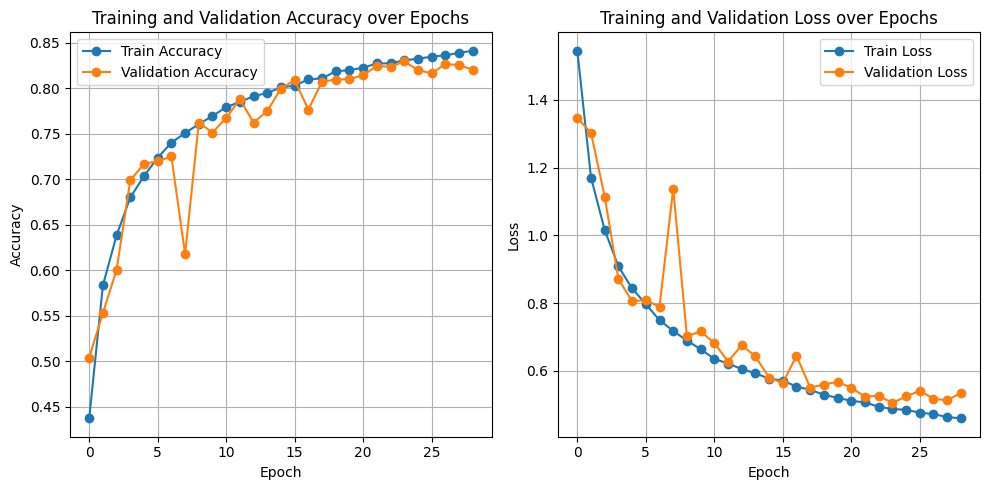

Accuracy: 82.99%


In [ ]:
def plot_convergence():

  plt.figure(figsize=(10, 5))
  # Accuracy plot
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid(True)
  plt.legend()

  # Loss plot
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], marker='o', label='Train Loss')
  plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
  plt.title('Training and Validation Loss over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.legend()

  plt.tight_layout()
  plt.show()


plot_convergence()


scores = model.evaluate(test_datagen.flow(X_test, y_cat_test,batch_size=32), verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

- https://keras.io/2.15/api/
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- https://www.tensorflow.org/api_docs/python/tf/keras/layers
- https://keras.io/2.15/api/callbacks/
- https://keras.io/api/layers/initializers/
- https://keras.io/api/callbacks/early_stopping/
- https://keras.io/api/callbacks/reduce_lr_on_plateau/
- https://keras.io/api/callbacks/csv_logger/


